In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from astropy.io import ascii, fits
#from astropy.modeling import fitting, FittableModel, Fittable2DModel, Fittable1DModel, Parameter, custom_model
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
from MUSE_Models import MUSE_3D_OIII, MUSE_3D_residual, PNextractor
%config InlineBackend.figure_format = 'retina'

In [11]:
# functions

hdulist = fits.open("FCC167_data/FCC167_OIII_line_center.fits")
hdr = hdulist[0].header
raw_data = hdulist[0].data
y_data = hdr["NAXIS2"]
x_data = hdr["NAXIS1"]
wavelength = np.exp(hdr['CRVAL3']+np.arange(hdr["NAXIS3"])*hdr['CDELT3'])
# swap axes to y,x,wavelength
raw_data_list = np.array(raw_data).reshape(len(wavelength), x_data*y_data)
raw_data_list = np.swapaxes(raw_data_list, 1, 0)
# Check for nan values
raw_data_list[np.isnan(raw_data_list)]=0.001
raw_data_cube = raw_data_list.reshape(y_data, x_data, len(wavelength))

n_pixels=11


# Read in x and y coordinates, in reagrds to 441x315 map.
#sorted_x_y_list = sorted(x_y_list, key=lambda x: [x[1], x[0]])
#x_PNe = np.array([x[0] for x in x_y_list])
#y_PNe = np.array([y[1] for y in x_y_list])
x_start = 74
x_start1 = x_start + 241
y_start = 268
y_start1 = y_start - 10
x_noise = [
    # First Column
    x_start, x_start, x_start, x_start, 
    # Second Column
    x_start + 2* n_pixels/2, x_start + 2* n_pixels/2, x_start + 2* n_pixels/2, x_start + 2* n_pixels/2, x_start + 2*(n_pixels/2), 
    x_start + 2* n_pixels/2, x_start + 2* n_pixels/2,
    # Third Column
    x_start + 4* n_pixels/2, x_start + 4* n_pixels/2, x_start + 4* n_pixels/2, x_start + 4* n_pixels/2, 
    # Fourth Column
    x_start + 6* n_pixels/2, x_start + 6* n_pixels/2, x_start + 6* n_pixels/2, x_start + 6* n_pixels/2, x_start + 6* n_pixels/2,
    # Fifth Column
    x_start + 8* n_pixels/2, x_start + 8* n_pixels/2, x_start + 8* n_pixels/2, x_start + 8* n_pixels/2, x_start + 8* n_pixels/2, x_start + 8* n_pixels/2,
    # sixth Column
    x_start1, x_start1, x_start1,
    #
    x_start1+ 2* n_pixels/2, x_start1+ 2* n_pixels/2, x_start1+ 2* n_pixels/2,
    #
    x_start1+ 4* n_pixels/2, x_start1+ 4* n_pixels/2, x_start1+ 4* n_pixels/2, x_start1+ 4* n_pixels/2, x_start1+ 4* n_pixels/2,
    #
    260, 260 + 2* n_pixels/2,
    #
    267, 267, 267 + 2 * n_pixels/2, 267 + 2 * n_pixels/2, 
    #
    194, 194, 194 + 2* n_pixels/2, 194,
    #
    200, 240, 185, 193, 193 - 2*n_pixels/2, 250, 250 + 2*n_pixels/2, 290, 290 + 2*n_pixels/2, 220, 160, 212, 205,
         ]
y_noise = [
    # First Column rows
    y_start-2*n_pixels/2, y_start - 4*(n_pixels/2), y_start - 6*(n_pixels/2), y_start - 8*(n_pixels/2),
    # Second Column rows
    y_start, y_start-2*n_pixels/2, y_start - 4*(n_pixels/2), y_start - 6*(n_pixels/2), y_start - 8*(n_pixels/2), y_start - 10*(n_pixels/2), y_start - 12*(n_pixels/2),
    # Third Column rows
    y_start+2*(n_pixels/2), y_start - 4*(n_pixels/2), y_start - 6*(n_pixels/2), y_start - 8*(n_pixels/2),
    # Fourth Column rows
    y_start + 2*(n_pixels/2), y_start - 4*(n_pixels/2), y_start - 6*(n_pixels/2), y_start - 8*(n_pixels/2), y_start - 12*(n_pixels/2),
    # Fifth Column rows
    y_start, y_start - 2*(n_pixels/2), y_start - 8*(n_pixels/2), y_start - 14*(n_pixels/2),  y_start - 16*(n_pixels/2),  y_start - 18*(n_pixels/2),
    # sixth column rows
    y_start1, y_start1 -2*n_pixels/2, y_start1- 4*(n_pixels/2),
    #
    y_start1, y_start1 -2*n_pixels/2, y_start1- 4*(n_pixels/2),
    #
    y_start1- 4*(n_pixels/2), y_start1- 6*(n_pixels/2), y_start1- 8*(n_pixels/2), y_start1- 10*(n_pixels/2), y_start1- 12*(n_pixels/2),
    #
    253, 253 - 2*(n_pixels/2),
    #
    147, 147 - 2*(n_pixels/2), 147, 147 + 2*(n_pixels/2),
    #
    98, 98 - 2* n_pixels/2, 98, 98 - 4* n_pixels/2,
    #
    350, 335, 198, 244, 244, 75, 75, 295, 295, 60, 307, 318, 158,
         ]


coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]

x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

# Retrieve the respective spectra for each PNe source

flatten = lambda l: [item for sublist in l for item in sublist]

noise_cube = np.array([PNextractor(x+3, y, n_pixels, raw_data_cube, wavelength, dim=2.) for x,y in zip(x_noise, y_noise)])


101


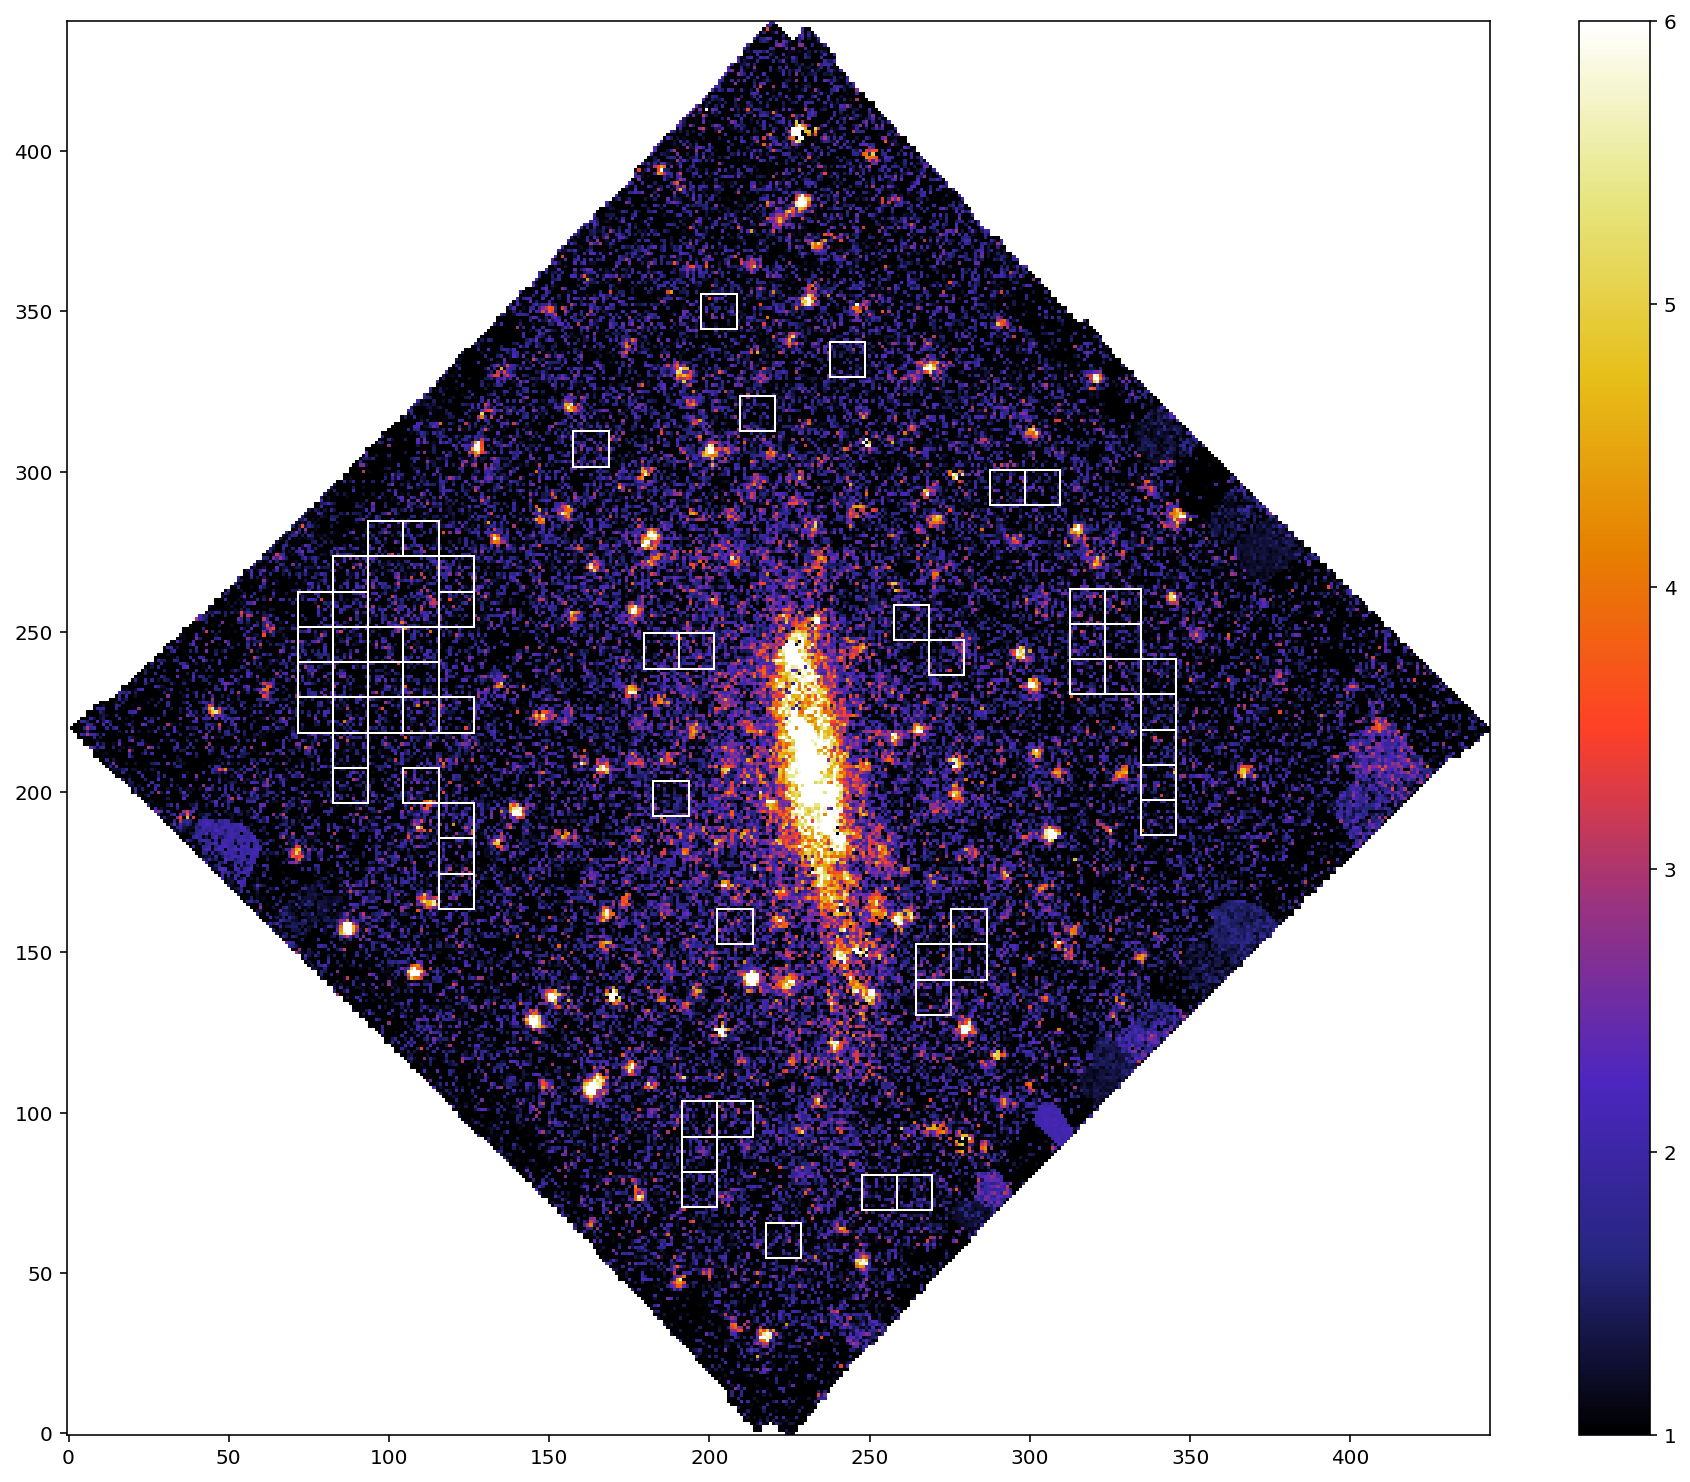

In [12]:
## Plot map
A_rN = np.load("exported_data/FCC167/A_rN.npy")
A_rN_shape = A_rN.reshape(441,444)

print(len(x_PNe))

plt.figure(2,figsize=(16,13))
plt.imshow(A_rN_shape, origin="lower", cmap="CMRmap", vmin=1, vmax=6)
cb = plt.colorbar()
#plt.savefig("Plots/FCC167_A_rN_tmp.png")
#plt.axhline(210)
#plt.axvline(230)
for i, (x,y) in enumerate(zip(x_noise, y_noise)):
    ax = plt.gca()
    ax.add_patch(Rectangle((x+3-n_pixels/2, y-n_pixels/2), n_pixels, n_pixels, fill=False, edgecolor="white"))
    plt.draw()

In [18]:
# create Pandas data frame for values
PNe_df = pd.DataFrame(columns=("PNe number", "Total Flux", "Flux error", "V (km/s)", "m 5007", "M 5007", "M 5007 error","A/rN"))
PNe_df["PNe number"] = np.arange(1,len(x_noise)+1)
# .loc(Row, column name)

#construct error cube
error_cube = np.zeros((len(x_noise), n_pixels**2, len(wavelength)))

for PNe_num in np.arange(0, len(x_noise)):
    list_of_std = [np.abs(np.std(spec)) for spec in noise_cube[PNe_num]]
    error_cube[PNe_num] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]

In [19]:
# Parameter setup

PNe_params = Parameters()
PNe_params.add('moffat_amp', value=100., min=0.0001)
PNe_params.add('x_0', value=(n_pixels/2))#, min=0.01, max=n_pixels)
PNe_params.add('y_0', value=(n_pixels/2))#, min=0.01, max=n_pixels)
PNe_params.add("FWHM", value=4.53, min=0.001, max=20., vary=False)
PNe_params.add("beta", value=1.4, min=0.001, max=20., vary=False) 
PNe_params.add("mean", value=5035., min=4980, max=5070)
PNe_params.add("Gauss_std", value=1.19, vary=False) # LSF, instrumental resolution.
PNe_params.add("Gauss_bkg",  value=0.001, min=-200., max=200.)
PNe_params.add("Gauss_grad", value=0.001, min=-2., max=2.)


# Gamma value=2.4325876573207847 +/- 0.0251 
# Alpha value=1.73296673762045 +/- 0.0175

In [20]:
# useful value storage setup

total_Flux = np.zeros(len(x_noise))
residuals_list = np.zeros(len(x_noise))
A_OIII_list = np.zeros(len(x_noise))
F_OIII_xy_list = np.zeros((len(x_noise), len(noise_cube[0])))
M_amp_list = np.zeros(len(x_noise))
mean_wave_list = np.zeros(len(x_noise))

# error lists
moff_A_err = np.zeros(len(x_noise))
x_0_err = np.zeros(len(x_noise))
y_0_err = np.zeros(len(x_noise))
mean_wave_err = np.zeros(len(x_noise))

stddev_list = np.zeros(len(x_noise))
list_of_x = np.zeros(len(x_noise))
list_of_y = np.zeros(len(x_noise))
c = 299792458.0

for PNe_num in np.arange(0, len(x_noise)):
    useful_stuff = []
    #run minimizer fitting routine
    results = minimize(MUSE_3D_residual, PNe_params, args=(wavelength, x_fit, y_fit, noise_cube[PNe_num], error_cube[PNe_num], PNe_num, useful_stuff), nan_policy="propagate")
    # store data in Pandas DF
    PNe_df.loc[PNe_num, "Total Flux"] = useful_stuff[0][0]
    PNe_df.loc[PNe_num, "V (km/s)"] = (c * (results.params["mean"] - 5006.8) / 5006.8) / 1000
    # Store values in numpy arrays
    stddev_list[PNe_num] = results.params["Gauss_std"]
    residuals_list[PNe_num] = useful_stuff[0][1]
    A_OIII_list[PNe_num] = useful_stuff[0][2]
    F_OIII_xy_list[PNe_num] = useful_stuff[0][3]
    M_amp_list[PNe_num] = results.params["moffat_amp"]
    list_of_x[PNe_num] = results.params["x_0"]
    list_of_y[PNe_num] = results.params["y_0"]
    mean_wave_list[PNe_num] = results.params["mean"]
    #save errors
    moff_A_err[PNe_num] = results.params["moffat_amp"].stderr
    x_0_err[PNe_num] = results.params["x_0"].stderr
    y_0_err[PNe_num] = results.params["y_0"].stderr
    mean_wave_err[PNe_num] = results.params["mean"].stderr

# Signal to noise and Magnitude calculations
A_by_rN = A_OIII_list / residuals_list
PNe_df["A/rN"] = A_by_rN

def log_10(x):
    return np.log10(x)

PNe_df["m 5007"] = -2.5 * PNe_df["Total Flux"].apply(log_10) - 13.74
dM = 5. * np.log10(18.71) + 25  #31.28 #5. * np.log10(16.4) + 25
PNe_df["M 5007"] = PNe_df["m 5007"] - dM

In [128]:
PNe_df

,PNe number,Total Flux,Flux error,V (km/s),m 5007,M 5007,M 5007 error,A/rN,stddev,gamma,alpha
0,1,1.7094e-22,NaN,76.2431,40.677892,9.397892,NaN,0.000040,1.19,2.14432,1.533
1,2,3.39924e-18,NaN,-79.2416,29.931547,-1.348453,NaN,1.080188,1.19,2.14432,1.533
2,3,3.16051e-18,NaN,120.557,30.010605,-1.269395,NaN,0.945092,1.19,2.14432,1.533
3,4,1.48965e-18,NaN,141.01,30.827290,-0.452710,NaN,0.404828,1.19,2.14432,1.533
4,5,5.06141e-18,NaN,-101.752,29.499321,-1.780679,NaN,1.379993,1.19,2.14432,1.533
5,6,4.57381e-18,NaN,85.5567,29.609306,-1.670694,NaN,1.040955,1.19,2.14432,1.533
6,7,2.67554e-18,NaN,128.382,30.191473,-1.088527,NaN,0.518169,1.19,2.14432,1.533
7,8,4.84034e-18,NaN,34.5379,29.547810,-1.732190,NaN,1.224301,1.19,2.14432,1.533
8,9,4.64145e-18,NaN,-51.4197,29.593365,-1.686635,NaN,1.426210,1.19,2.14432,1.533
9,10,3.58757e-18,NaN,131.148,29.873000,-1.407000,NaN,0.866795,1.19,2.14432,1.533


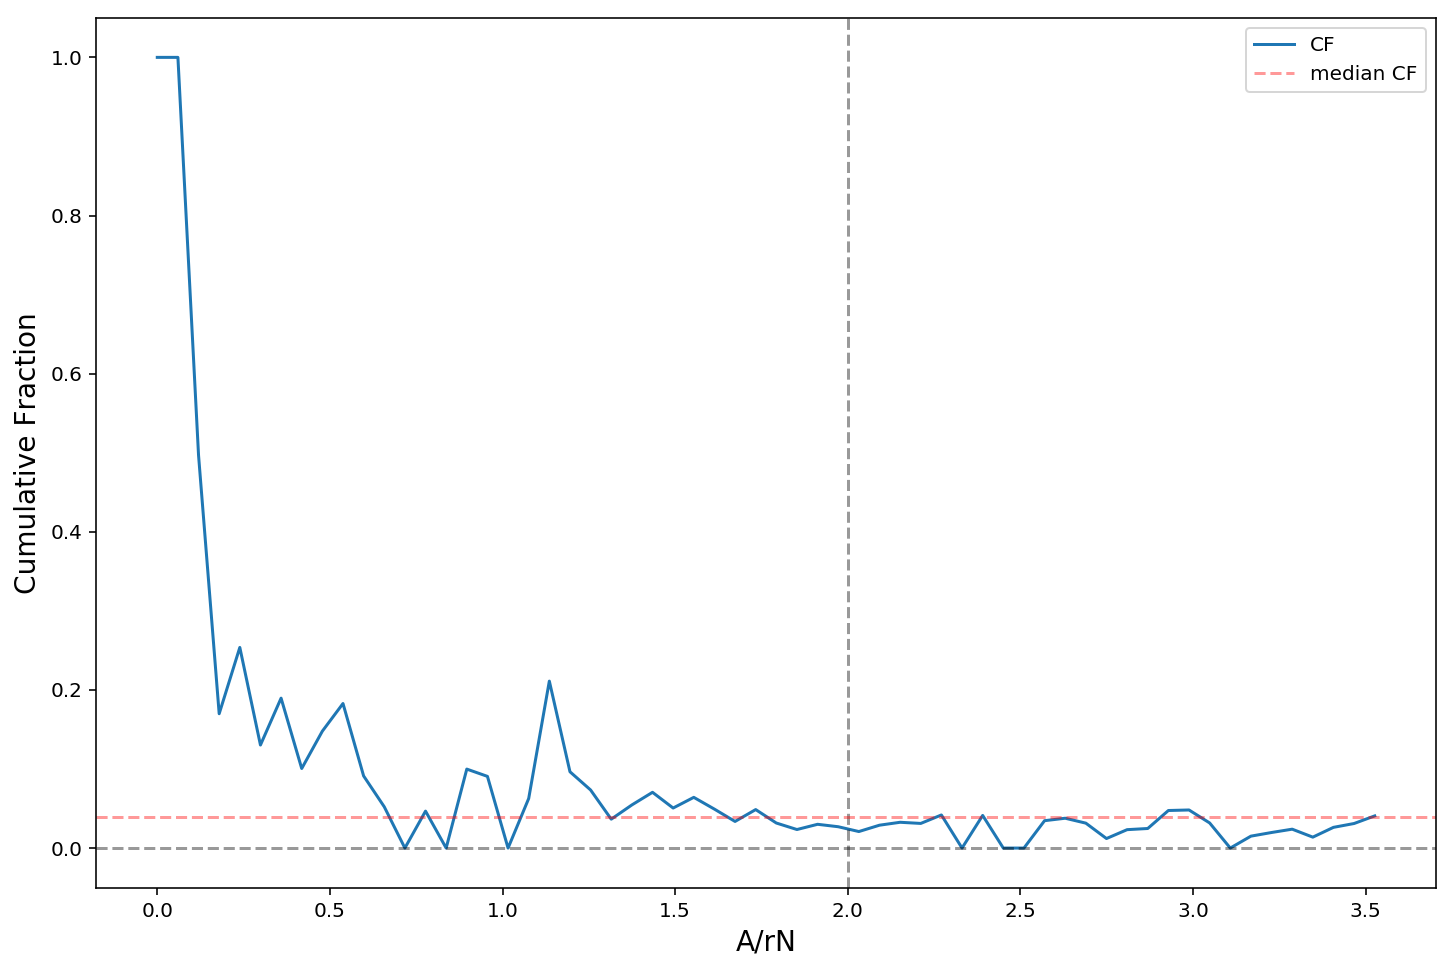

In [25]:
test_cum_sum = np.cumsum(PNe_df["A/rN"])
plt.figure(figsize=(12,8))
plt.plot(np.linspace(0,np.max(PNe_df["A/rN"]), len(test_cum_sum)), PNe_df["A/rN"]/test_cum_sum, label="CF")
plt.xlabel("A/rN", fontsize=14)
plt.ylabel("Cumulative Fraction", fontsize=14)
plt.axhline(y=0, c="k", ls="dashed", alpha=0.4)
plt.axvline(x=2, c="k", ls="dashed", alpha=0.4)
plt.axhline(y=np.median(PNe_df["A/rN"]/test_cum_sum), c="r", ls="dashed", alpha=0.4, label="median CF")
plt.legend()
#plt.savefig("Plots/FCC167/CF.png")

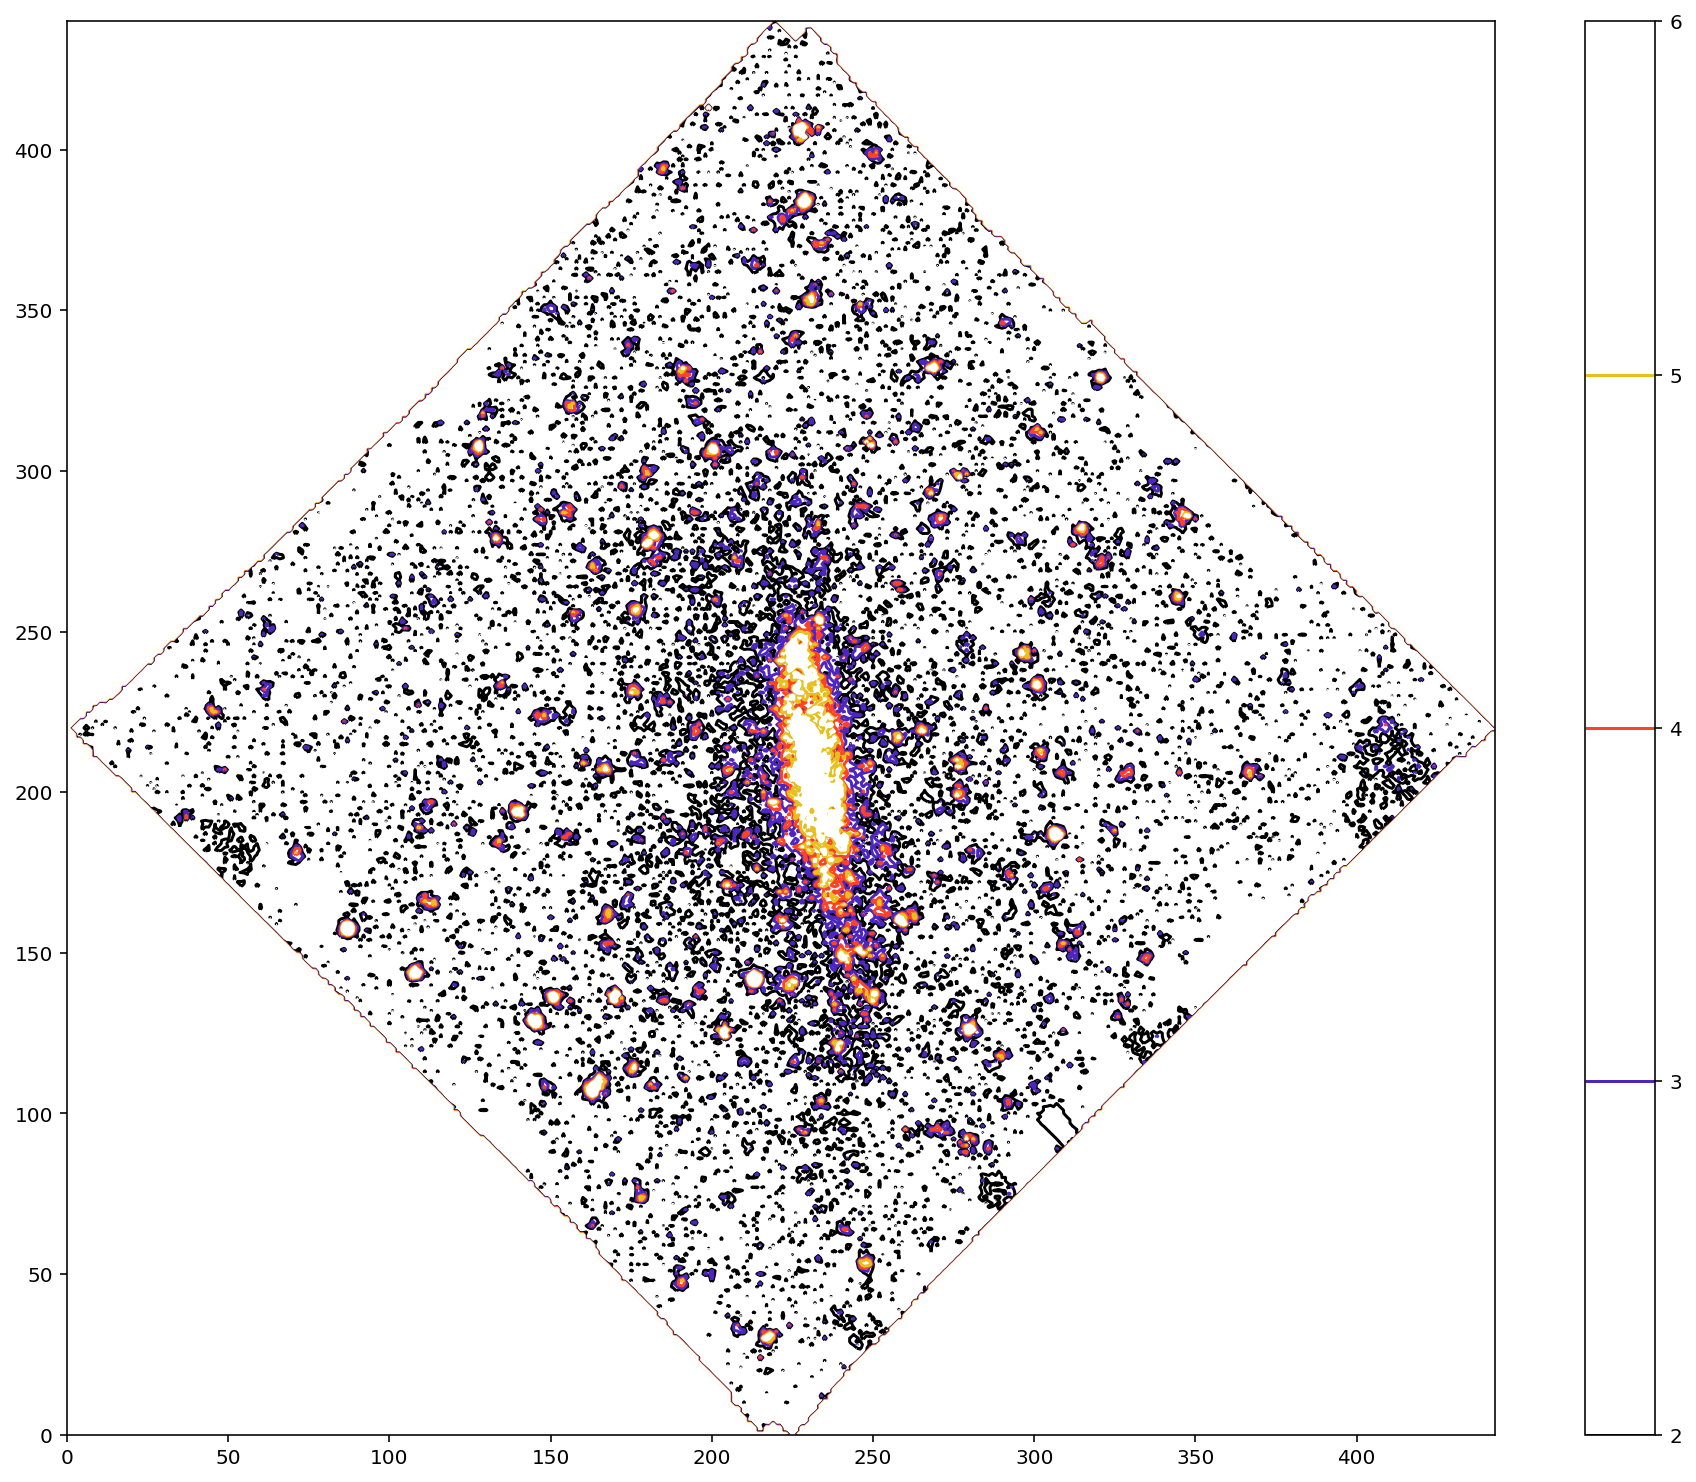

In [143]:
plt.figure(3, figsize=(16,13))
contour_x = np.arange(x_data)
contour_y = np.arange(y_data)
levels = [2.,3.,4., 5., 6.,]
cnt = plt.contour(contour_x,contour_y, A_rN_shape, levels=levels, cmap="CMRmap")
cb = plt.colorbar()